In [25]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import geopandas as gpd
import seaborn as sns
from HierarchicalGeoClustering import TreeClusters, Clustering 
import shapely 
from matplotlib import cm
import pandas as pd
import warnings
import hdbscan
import pickle5 as pickle
warnings.filterwarnings('ignore')

In [26]:
# df_polygons_tree.to_pickle('../output/toy_gep.pickle')
with open("../output/toy_gep.pickle", "rb") as fh:
    df_polygons_tree = pickle.load(fh)
df_polygons_tree.head()

,Polygon,name,level,parent
0,POLYGON ((0.1591601996929714 0.580298990728507...,root,0,
1,POLYGON ((0.4071121551098488 0.390763274864394...,l1_c0,1,root
2,POLYGON ((0.4314899945789328 0.513441916759204...,l1_c0_l2_c0,2,l1_c0
3,POLYGON ((0.4448622423232922 0.389205405282803...,l1_c0_l2_c1,2,l1_c0
4,POLYGON ((0.4449054440526734 0.545459339707125...,l1_c0_l2_c0_l3_c0,3,l1_c0_l2_c0


In [27]:
def tree_from_df(df_poligons):
    """
    Recreate a tree from the polygons returning a tree structure
    """
    tree_c = TreeClusters.TreeClusters()
    
    for level in df_poligons.level.unique():
        level_nodes = []
        for row, polygon_node in df_poligons[df_poligons['level']==level].iterrows():
            node = TreeClusters.NodeCluster(name=polygon_node['name'])
            if polygon_node['parent']  != '':
                parents = tree_c.get_level(level-1)
                parents_goo = [pa for pa in parents if pa.name == polygon_node['parent']]
                node.parent = parents_goo[0]
            node.polygon_cluster = polygon_node['Polygon']

            level_nodes.append(node)
        tree_c.levels_nodes.append(level_nodes)
    tree_c.root = tree_c.get_level(0)[0]
    return tree_c
                

In [28]:
tree_v = tree_from_df(df_polygons_tree)

In [29]:
### Añadirle puntos
count = 0
for level in tree_v.levels_nodes:
    for node in level:
        rand_points  = node.create_random_points(35-3*count, random_state=127 )
        for node_child in node.children:
            rand_points= [po for po in rand_points if node_child.polygon_cluster.contains(po) != True ]  
        node.point_cluster_noise = shapely.geometry.MultiPoint(rand_points)
    count +=1

(-0.04007007305850546,
 1.0218020164410249,
 -0.02109604495381983,
 0.9914107666998462)

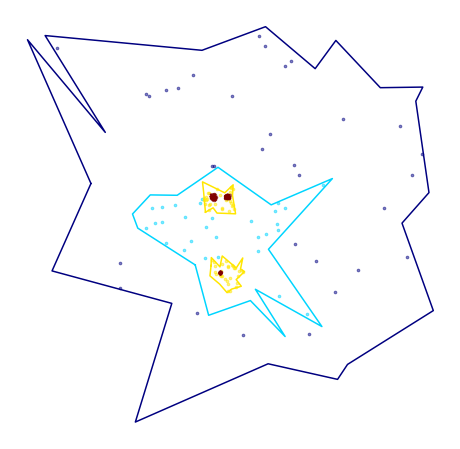

In [30]:
fig, axs = plt.subplots( figsize=(8,8))
tree_v.visualize(axs, size_cluster=7 , polygon=True)
axs.axis('off')

In [31]:
tree_v_points= tree_v.get_points_tree()
X_2=np.array([[p.x,p.y] for p in tree_v_points])
dic_points={'points':[X_2], 'parent':''}

In [32]:
tree_adaptative= Clustering.recursive_clustering_tree(
                        dic_points,
                        levels_clustering = 3,
                        algorithm = 'adaptative_DBSCAN'
                )
tree_OPTICS= Clustering.recursive_clustering_tree(
                        dic_points,
                        levels_clustering = 3,
                        algorithm = 'optics'
                )
tree_HDBSCAN = Clustering.recursive_clustering_tree(
                        dic_points,
                        levels_clustering = 3,
                        algorithm = 'hdbscan'
                )

The min_k value is too large for the number of points returns empty clusters
The min_k value is too large for the number of points returns empty clusters
The min_k value is too large for the number of points returns empty clusters


In [33]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True, leaf_size=40,metric='euclidean', )
clusterer.fit(X_2)


# hdbscan.HDBSCAN  dic_points

HDBSCAN(gen_min_span_tree=True)

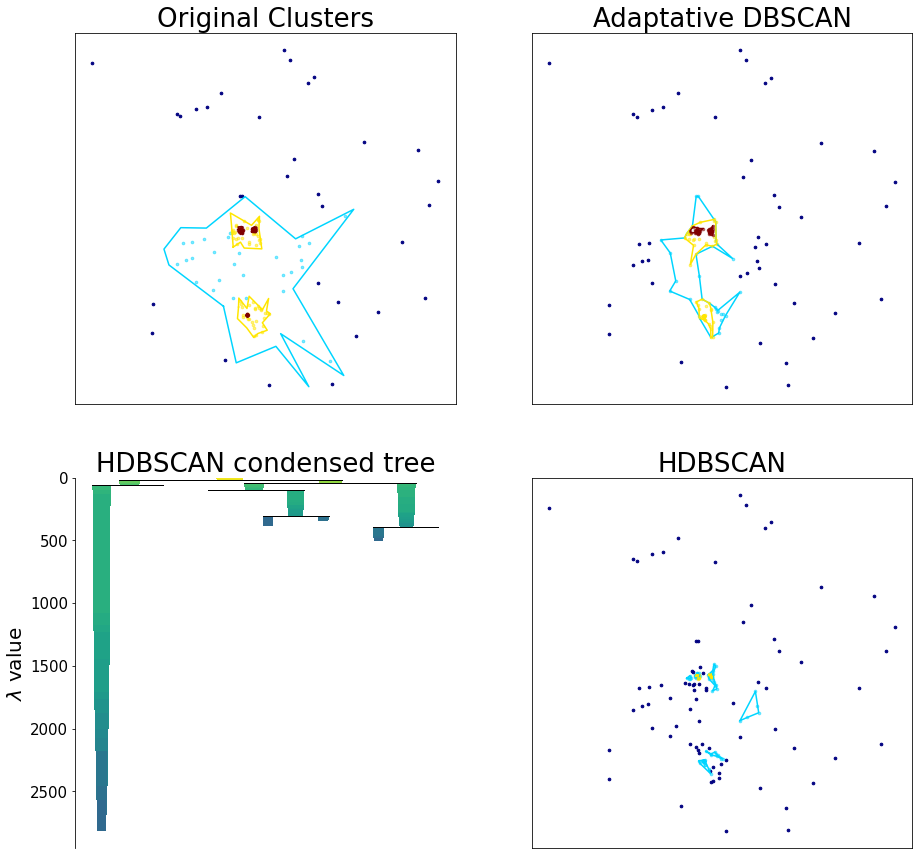

In [56]:
fig, axs = plt.subplots(2,2, figsize=(15,15))
axs = axs.ravel()

jet =  plt.get_cmap('jet')
norm = matplotlib.colors.Normalize(vmin=0, vmax=3)
colors= cm.ScalarMappable(norm=norm, cmap=jet)

node_root= tree_v.root

x_root = [p.x for p in node_root.point_cluster_noise] 
y_root = [p.y for p in node_root.point_cluster_noise] 


axs[0].scatter(x_root, y_root, s=7, color = colors.to_rgba(0))

for i in tree_v.get_level(1):
    i.viewer_cluster(axs[0],
                   color_cluster= colors.to_rgba(1),
                   size_cluster=7,
                   polygon_color= colors.to_rgba(1),
                   polygon=True
                  )
    
for i in tree_v.get_level(2):
    i.viewer_cluster(axs[0],
                   color_cluster= colors.to_rgba(2),
                   size_cluster=7,
                   polygon_color= colors.to_rgba(2),
                   polygon=True
                  )

for i in tree_v.get_level(3):
    i.viewer_cluster(axs[0],
                   color_cluster= colors.to_rgba(3),
                   size_cluster=7,
                   polygon_color= colors.to_rgba(3),
                   polygon=True
                  )

# tree_v.visualize(axs[0], levels=[1,2,3],  size_cluster=7 )

axs[0].xaxis.set_ticklabels([])
axs[0].xaxis.set_ticks([])
axs[0].yaxis.set_ticklabels([])
axs[0].yaxis.set_ticks([])
axs[0].title.set_size(26)
axs[0].title.set_text('Original Clusters')


node_root_adap = tree_adaptative.root
x_root_adap = [p.x for p in node_root_adap.point_cluster_noise] 
y_root_adap = [p.y for p in node_root_adap.point_cluster_noise] 
axs[1].scatter(x_root_adap, y_root_adap, s=7, color = colors.to_rgba(0))
for i in tree_adaptative.get_level(1):
    i.viewer_cluster(axs[1],
                   color_cluster= colors.to_rgba(1),
                   size_cluster=7,
                   polygon_color= colors.to_rgba(1),
                   polygon=True
                  )
    
for i in tree_adaptative.get_level(2):
    i.viewer_cluster(axs[1],
                   color_cluster= colors.to_rgba(2),
                   size_cluster=7,
                   polygon_color= colors.to_rgba(2),
                   polygon=True
                  )

for i in tree_adaptative.get_level(3):
    i.viewer_cluster(axs[1],
                   color_cluster= colors.to_rgba(3),
                   size_cluster=7,
                   polygon_color= colors.to_rgba(3),
                   polygon=True
                  )

# tree_adaptative.visualize(axs[1],size_cluster=7, polygon=True)
axs[1].title.set_size(26)
axs[1].title.set_text('Adaptative DBSCAN')
axs[1].xaxis.set_ticklabels([])
axs[1].xaxis.set_ticks([])
axs[1].yaxis.set_ticklabels([])
axs[1].yaxis.set_ticks([])
clusterer.condensed_tree_.plot(axis= axs[2] ,
                                     log_size=True,
                                     leaf_separation = 2,
                                     select_clusters=False,
                                     colorbar=False,
                                     max_rectangles_per_icicle= 25)


axs[2].title.set_size(26)
axs[2].set_ylabel('$\lambda$ value', fontsize = 20)
axs[2].title.set_text('HDBSCAN condensed tree')
for tick in axs[2].yaxis.get_major_ticks():
    tick.label.set_fontsize(15)




###### HDBSCAN
node_root_hbscan = tree_HDBSCAN.root
x_root_hdbscan = [p.x for p in node_root_hbscan.point_cluster_noise] 
y_root_hdbscan = [p.y for p in node_root_hbscan.point_cluster_noise]
axs[3].scatter(x_root_hdbscan, y_root_hdbscan, s=7, color = colors.to_rgba(0))

for i in tree_HDBSCAN.get_level(1):
    i.viewer_cluster(axs[3],
                   color_cluster= colors.to_rgba(1),
                   size_cluster=7,
                   polygon_color= colors.to_rgba(1),
                   polygon=True
                  )
    
for i in tree_HDBSCAN.get_level(2):
    i.viewer_cluster(axs[3],
                   color_cluster= colors.to_rgba(2),
                   size_cluster=7,
                   polygon_color= colors.to_rgba(2),
                   polygon=True
                  )

for i in tree_HDBSCAN.get_level(3):
    i.viewer_cluster(axs[3],
                   color_cluster= colors.to_rgba(3),
                   size_cluster=7,
                   polygon_color= colors.to_rgba(3),
                   polygon=True
                  )

# tree_HDBSCAN.visualize(axs[3],size_cluster=7, polygon=True)

axs[3].xaxis.set_ticklabels([])
axs[3].xaxis.set_ticks([])
axs[3].yaxis.set_ticklabels([])
axs[3].yaxis.set_ticks([])
axs[3].title.set_size(26)
axs[3].title.set_text('HDBSCAN')
# fig.savefig('../output/toy_data.png', dpi=600)
fig.savefig('../output/toy_data.pdf', dpi=600)

<AxesSubplot:ylabel='$\\lambda$ value'>

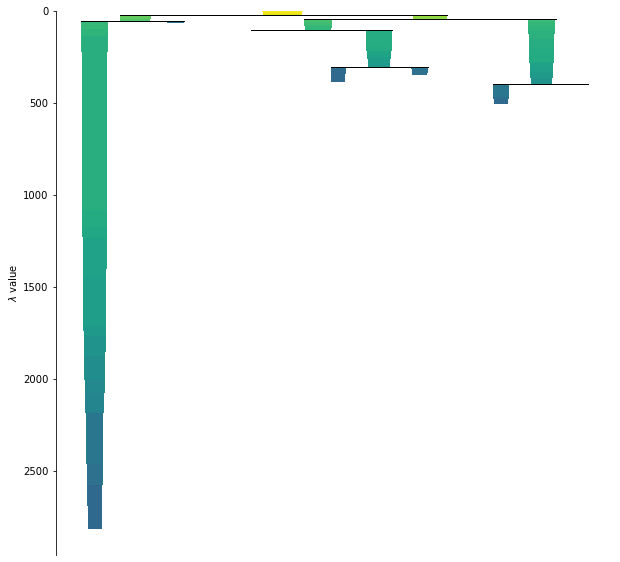

In [47]:
fig, axs = plt.subplots( figsize=(10,10))

clusterer.condensed_tree_.plot(axis= axs ,
                                     log_size=True,
                                     leaf_separation = 2,
                                    select_clusters=False,
                                   colorbar=False,
                                   max_rectangles_per_icicle= 25
                              )


AttributeError: 'AxesSubplot' object has no attribute 'colorbar'